# Pilot: Depth Discrimination Analysis (N=9)

In [94]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from scipy.stats import sem 
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 


In [213]:
def combineCSVs(datafolder, num_discrim_trials):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    
    returns:
        (1) combined dataframe of all discrimination data 
        (2) combined dataframe of all scene property rating data 
    """
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        discrim_data = []
        properties_data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                df_discrim = df[0:num_discrim_trials]
                discrim_data.append(df_discrim)
                # row 96 should be ignored - artifact of logging 
                df_properties = df[num_discrim_trials+1:]
                properties_data.append(df_properties)
                

        discrim_frame = pd.concat(discrim_data, axis=0, ignore_index=True)
        properties_frame = pd.concat(properties_data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            df = pd.read_csv(datafolder, index_col=None, header=0)
            df_discrim = df[0:num_discrim_trials]
            discrim_data.append(df_discrim)
            # row 96 should be ignored - artifact of logging 
            df_properties = df[num_discrim_trials+1:]
            properties_data.append(df_properties)
 
    return discrim_frame, properties_frame

In [214]:

# data_path = '/Users/prachi/Documents/depth_duration/depth_discrimination/depth_discrimination_MTurk/data'

data_path = '/Users/prachi/Documents/depth_duration/depth_discrimination/v2_depthdiscrim_pilot1_data'



In [215]:
raw_discrim, raw_ratings = combineCSVs(data_path, 40)

In [216]:
all_subjIDs = raw_discrim.subjID.unique()
len(all_subjIDs)

8

In [217]:
raw_discrim

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,log_sceneDuration2,log_mask2,unitSelection,meanDepth_rating,navigability_rating,rated_stimulus,rating_RT,experimentTime,totalTime,age
0,670721,DepthScenes,v2_duration_discrimination,discrim_jsons/shuffled_g0.json,http://54.211.221.249/DepthDuration/v2_depth_d...,4,1367,768,1367,768,...,249,499,NaN,NaN,NaN,NaN,NaN,884095,1814265,40
1,670721,DepthScenes,v2_duration_discrimination,discrim_jsons/shuffled_g0.json,http://54.211.221.249/DepthDuration/v2_depth_d...,4,1367,768,1367,768,...,249,500,NaN,NaN,NaN,NaN,NaN,884095,1814265,40
2,670721,DepthScenes,v2_duration_discrimination,discrim_jsons/shuffled_g0.json,http://54.211.221.249/DepthDuration/v2_depth_d...,4,1367,768,1367,768,...,248,500,NaN,NaN,NaN,NaN,NaN,884095,1814265,40
3,670721,DepthScenes,v2_duration_discrimination,discrim_jsons/shuffled_g0.json,http://54.211.221.249/DepthDuration/v2_depth_d...,4,1367,768,1367,768,...,999,501,NaN,NaN,NaN,NaN,NaN,884095,1814265,40
4,670721,DepthScenes,v2_duration_discrimination,discrim_jsons/shuffled_g0.json,http://54.211.221.249/DepthDuration/v2_depth_d...,4,1367,768,1367,768,...,1000,500,NaN,NaN,NaN,NaN,NaN,884095,1814265,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,343974,DepthScenes,v2_duration_discrimination,discrim_jsons/shuffled_g0_dr.json,http://54.211.221.249/DepthDuration/v2_depth_d...,1,1366,615,1366,768,...,1001,498,NaN,NaN,NaN,NaN,NaN,725498,930641,34
316,343974,DepthScenes,v2_duration_discrimination,discrim_jsons/shuffled_g0_dr.json,http://54.211.221.249/DepthDuration/v2_depth_d...,1,1366,615,1366,768,...,999,500,NaN,NaN,NaN,NaN,NaN,725498,930641,34
317,343974,DepthScenes,v2_duration_discrimination,discrim_jsons/shuffled_g0_dr.json,http://54.211.221.249/DepthDuration/v2_depth_d...,1,1366,615,1366,768,...,1000,505,NaN,NaN,NaN,NaN,NaN,725498,930641,34
318,343974,DepthScenes,v2_duration_discrimination,discrim_jsons/shuffled_g0_dr.json,http://54.211.221.249/DepthDuration/v2_depth_d...,1,1366,615,1366,768,...,1000,499,NaN,NaN,NaN,NaN,NaN,725498,930641,34


In [229]:
all_ages = raw_discrim.age.unique()
all_ages

array([40, 35, 56, 38, 46, 42, 34])

## <font color='red'> Data Cleaning </font> 



In [218]:
def catchTrial_cleaning(df, correct_requirement, catch_stimuli):
    '''
    Participants complete 8 catch trials total to ensure that they are doing the task.
    If less than 7/8 catch trials are correct, the participant is excluded.  
    '''
    all_subjIDs = df.subjID.unique()
    remove = []
    subj_sequence = {}
    df2_list = []
    sequence_count = {'discrim_jsons/shuffled_g0_dr.json': 0,
                      'discrim_jsons/shuffled_g0_rotated_dr.json': 0,
                      'discrim_jsons/shuffled_g0_rotated.json': 0, 
                      'discrim_jsons/shuffled_g0.json': 0}
    for subj in all_subjIDs:
        count_correct = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning
        # 
        subj_sequence[subj] = subj_df.sequenceName.unique()[0]
        
        # remove trials that are outside the outlier range
        c = 0
        c_missed = 0
        for idx, row in subj_df.iterrows():
            stim1 = row['stimulus_0']
            stim2 = row['stimulus_1']
            if stim1.split('/')[1] in catch_stimuli or stim2.split('/')[1] in catch_stimuli:
                c += 1
                depth0 = row["actual_depth_0"]
                depth1 = row["actual_depth_1"]
                if depth0 < depth1:
                    correct_choice = 0
                if depth0 > depth1:
                    correct_choice = 1
                choice = row["discrim_choice"]
                if choice == 2.0:
                    c_missed += 1
                if choice == correct_choice:
                    count_correct += 1
                # remove catch trial 
                cleaned_subj_df.drop([idx], inplace=True)
#                 print(depth0, depth1, correct_choice, choice)
        print(c_missed, 'Number of catch trials where participants did not see the target')
#         print(c)
        print(count_correct)
        if count_correct < correct_requirement:
            print('Number correct:', count_correct)
            remove.append(subj)
        else:
            sequence_count[subj_df.sequenceName.unique()[0]] += 1
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print("Number of participants that did not pass the catch trial check:", len(remove))
    print("Participants that were removed:",remove)
    print("Sequences that need to be replaced:")
    for subj in remove:
        print(subj_sequence[subj])
    print("Sequence count:")
    print(sequence_count)
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2
    
    

In [219]:
all_catch_stim = ['000375_2014-06-08_11-17-29_260595134347_rgbf000133-resize_2',
              '000569_2014-06-09_22-51-47_260595134347_rgbf000141-resize_3',
              '000787_2014-06-08_22-33-53_260595134347_rgbf000175-resize_1',
              '002072_2014-06-24_21-48-06_260595134347_rgbf000115-resize_0',
              '002364_2014-06-28_20-11-05_260595134347_rgbf000042-resize_0',
              '002675_2014-06-13_16-08-49_094959634447_rgbf000151-resize_2',
              '003125_2014-05-12_10-39-22_094959634447_rgbf000100-resize_0',
              '003395_2014-05-20_15-39-18_094959634447_rgbf000101-resize_0',
              '000454_2014-06-08_16-37-28_260595134347_rgbf000048-resize_2',
              '000868_2014-06-09_20-49-52_260595134347_rgbf000064-resize_4',
              '000953_2014-06-08_11-42-19_260595134347_rgbf000083-resize_0',
              '001012_2014-06-08_23-19-38_260595134347_rgbf000057-resize_0',
              '001170_2014-06-17_15-43-44_260595134347_rgbf000096-resize_6',
              '001222_2014-06-17_16-24-06_260595134347_rgbf000073-resize_0',
              '001498_2014-06-19_17-45-14_260595134347_rgbf000129-resize_4',
              '001540_2014-06-20_17-01-05_260595134347_rgbf000086-resize_2']

In [220]:
catch_cleaned_discrim = catchTrial_cleaning(raw_discrim, 6, all_catch_stim)

0 Number of catch trials where participants did not see the target
3
Number correct: 3
0 Number of catch trials where participants did not see the target
7
0 Number of catch trials where participants did not see the target
6
0 Number of catch trials where participants did not see the target
7
0 Number of catch trials where participants did not see the target
4
Number correct: 4
0 Number of catch trials where participants did not see the target
8
0 Number of catch trials where participants did not see the target
8
0 Number of catch trials where participants did not see the target
6
Number of participants that did not pass the catch trial check: 2
Participants that were removed: [670721, 579100]
Sequences that need to be replaced:
discrim_jsons/shuffled_g0.json
discrim_jsons/shuffled_g0_rotated.json
Sequence count:
{'discrim_jsons/shuffled_g0_dr.json': 3, 'discrim_jsons/shuffled_g0_rotated_dr.json': 1, 'discrim_jsons/shuffled_g0_rotated.json': 1, 'discrim_jsons/shuffled_g0.json': 1}


In [231]:
cleaned_ages = catch_cleaned_discrim.age.unique()
cleaned_ages

array([35, 56, 46, 42, 34])

#### URL Fragment Assignment 

'discrim_jsons/d0_dr.json': 1

'discrim_jsons/d0_rotated_dr.json': 2

'discrim_jsons/d0_rotated.json': 3 

'discrim_jsons/d0.json': 4

In [221]:
def RT_cleaning(df, outlier_range, num_trials):
    all_subjIDs = df.subjID.unique()
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning
        
        # calculate subject's average trial RT
        average_trial_RT = subj_df["trial_RT"].mean()
        std_trial_RT = subj_df["trial_RT"].std()
        p_outlier_range = [(average_trial_RT - (3*std_trial_RT)), (average_trial_RT + (3*std_trial_RT))]
        
        # remove trials that are outside the outlier range
        for idx, row in subj_df.iterrows():
            RT = row['trial_RT']
            if RT < outlier_range[0]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            try:
                if RT < p_outlier_range[0]:
                    cleaned_subj_df.drop([idx], inplace=True)
                    count += 1
                if RT > p_outlier_range[1]:
                    cleaned_subj_df.drop([idx], inplace=True)
                    count += 1
            except:
                print("Trial already removed")
                
        threshold = math.floor(num_trials * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print("Number of Participants with 10% or more trials outside their RT range:", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2


In [222]:
cleaned_discrim = RT_cleaning(catch_cleaned_discrim, [250,5000], 32)

Trial already removed
Trial already removed
Number of Participants with 10% or more trials outside their RT range: 1


In [223]:
def finalTrialCountCheck(df, num_trials):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column\n",
    all_subjIDs = df.subjID.unique()
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        threshold_trials_remaining = num_trials - math.floor(num_trials * 0.1)
        
        if count_trials <= threshold_trials_remaining:
            remove.append(subj)
    print("Number of Participants with >= 10% trials removed:", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
    
    print("Number of participants left:",len(df.subjID.unique()))
    
    return df

In [224]:
final_discrim = finalTrialCountCheck(cleaned_discrim, 32)

Number of Participants with >= 10% trials removed: 0
Number of participants left: 5


## Accuracy

In [225]:
def get_accuracy(df):
    """
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    for idx, row in df.iterrows():
        choice = row["discrim_choice"]
        if choice == 2.0:
            count_missed += 1
        else:    
            count_total += 1
            depth0 = row["actual_depth_0"]
            depth1 = row["actual_depth_1"]
            if depth0 < depth1:
                correct_choice = 0
            if depth0 > depth1:
                correct_choice = 1
            if depth0 == depth1:
                # case where depths are equal 
                correct_choice = None
            if choice == correct_choice:
                count_correct += 1
    
    return count_correct/count_total, count_correct, count_total, count_missed

In [226]:
overall_accuracy = get_accuracy(final_discrim)
overall_accuracy

(0.6037735849056604, 96, 159, 0)

#### Accuracy by Duration

In [227]:
discrim_250ms = final_discrim[final_discrim['duration'] == 250.0]
discrim_1000ms = final_discrim[final_discrim['duration'] == 1000.0]

In [228]:
accuracy_250 = get_accuracy(discrim_250ms)
accuracy_1000 = get_accuracy(discrim_1000ms)
accuracy_250, accuracy_1000

((0.6582278481012658, 52, 79, 0), (0.55, 44, 80, 0))

#### Accuracy by Duration and Depth Bin

In [128]:
investigate = []

In [129]:
depth_bins = np.arange(1,5,1)
depth_bins_accuracy_250 = {}
depth_bins_accuracy_1000 = {}

for _bin in depth_bins:
    bin_df = final_discrim[(final_discrim['actual_depth_0'] >= _bin) & (final_discrim['actual_depth_0'] < _bin + 1)]
    bin_df_250ms = bin_df[bin_df['duration'] == 250.0]
    bin_df_1000ms = bin_df[bin_df['duration'] == 1000.0]
    print(bin_df_250ms.shape)
    print(bin_df_1000ms.shape)
    
    acc_250 = get_accuracy(bin_df_250ms)
    acc_1000 = get_accuracy(bin_df_1000ms)
    
    if acc_1000[0] < 0.5:
        investigate.append(bin_df_1000ms)
    
    depth_bins_accuracy_250[round(_bin, 3)] = acc_250[0]
    depth_bins_accuracy_1000[round(_bin, 3)] = acc_1000[0]


(16, 33)
(16, 33)
(20, 33)
(12, 33)
(14, 33)
(18, 33)
(12, 33)
(20, 33)


In [130]:
len(investigate)

1

In [131]:
investigate[0][['subjID', 'stimulus_0', 'actual_depth_0', 'stimulus_1', 'actual_depth_1', 'discrim_choice']]

,subjID,stimulus_0,actual_depth_0,stimulus_1,actual_depth_1,discrim_choice
47,983483,depth_discrimination_stimuli/002043_2014-06-24...,2.8435,depth_discrimination_stimuli/001011_2014-06-08...,2.4730,0.0
70,983483,depth_discrimination_stimuli/000927_2014-06-09...,2.6785,depth_discrimination_stimuli/002678_2014-06-13...,2.1830,1.0
123,857994,depth_discrimination_stimuli/001011_2014-06-08...,2.4730,depth_discrimination_stimuli/002043_2014-06-24...,2.8435,1.0
156,857994,depth_discrimination_stimuli/002678_2014-06-13...,2.1830,depth_discrimination_stimuli/000927_2014-06-09...,2.6785,1.0
201,133786,depth_discrimination_stimuli/000502_2014-06-08...,2.4310,depth_discrimination_stimuli/001092_2014-06-15...,2.6935,0.0
205,133786,depth_discrimination_stimuli/001056_2014-06-08...,2.6625,depth_discrimination_stimuli/000749_2014-06-08...,2.3310,1.0
206,133786,depth_discrimination_stimuli/000869_2014-06-09...,2.2660,depth_discrimination_stimuli/000800_2014-06-08...,2.8000,0.0
212,133786,depth_discrimination_stimuli/002905_2014-06-03...,2.0295,depth_discrimination_stimuli/002340_2014-06-28...,2.4735,0.0
218,133786,depth_discrimination_stimuli/001055_2014-06-08...,2.4290,depth_discrimination_stimuli/000929_2014-06-09...,2.8680,1.0
219,133786,depth_discrimination_stimuli/001164_2014-06-17...,2.3540,depth_discrimination_stimuli/002118_2014-06-25...,2.6460,1.0


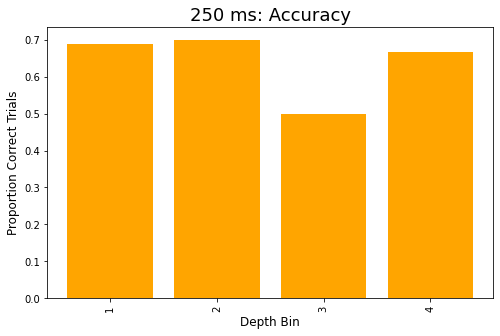

In [177]:
plt.figure(figsize = [8, 5])
plt.bar(range(len(depth_bins_accuracy_250)), list(depth_bins_accuracy_250.values()), align='center', color = 'orange')
plt.xticks(range(len(depth_bins_accuracy_250)), list(depth_bins_accuracy_250.keys()), rotation=90)
plt.xlabel("Depth Bin", fontsize = 12)
plt.ylabel("Proportion Correct Trials", fontsize = 12)
plt.title("250 ms: Accuracy", fontsize = 18)
plt.show()

In [133]:
# depthbin_2m = final_discrim[(final_discrim['actual_depth_0'] >= 2) & (final_discrim['actual_depth_0'] < _bin + 0.2)]

# depthbin_stim0 = []
# depthbin_stim1 = []
# depthbin_depthdiff = []
# for index, row in depthbin_2m.iterrows():
#     depthbin_stim0.append(row['stimulus_0'])
#     depthbin_stim1.append(row['stimulus_1'])
#     depthbin_depthdiff.append(abs(row['actual_depth_0'] - row['actual_depth_1']))
    

In [134]:
# i = 10
# depthbin_stim0[i], depthbin_stim1[i], depthbin_depthdiff[i]


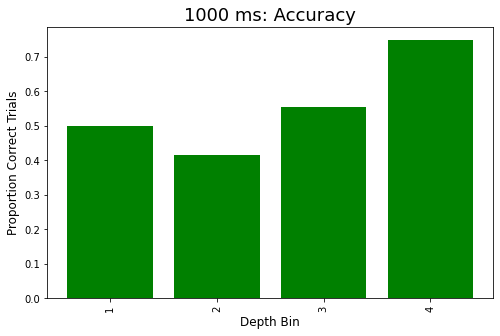

In [178]:
plt.figure(figsize = [8, 5])
plt.bar(range(len(depth_bins_accuracy_1000)), list(depth_bins_accuracy_1000.values()), align='center', color = 'green')
plt.xticks(range(len(depth_bins_accuracy_1000)), list(depth_bins_accuracy_1000.keys()), rotation=90)
plt.xlabel("Depth Bin", fontsize = 12)
plt.ylabel("Proportion Correct Trials", fontsize = 12)
plt.title("1000 ms: Accuracy", fontsize = 18)
plt.show()


#### Proportion Correct as a Function of Amount of Depth Difference

In [136]:
def depth_differences(df):
    """
    args:
        df  
    returns:
        array of depth differences, avg depth differences and std   
    """
    depth_diffs = []
    for idx, row in df.iterrows():
        depth0 = row["actual_depth_0"]
        depth1 = row["actual_depth_1"]
        
        diff = abs(depth0-depth1)
        depth_diffs.append(diff)
    
    depth_diffs = np.array(depth_diffs)
    
    return depth_diffs, np.mean(depth_diffs) ,np.std(depth_diffs)
    

In [137]:
all_depth_diffs = depth_differences(final_discrim)

# add depth difference column to dataframe 
final_discrim.insert(18, "depth_difference", all_depth_diffs[0])

In [138]:
final_discrim["depth_difference"]

40     0.5180
41     0.2840
42     0.5340
43     0.2625
45     0.4915
        ...  
273    0.5305
275    0.5285
276    0.2580
278    0.4215
279    0.4585
Name: depth_difference, Length: 128, dtype: float64

Mean & Std:  (0.3970468749999999, 0.09153597913577802)


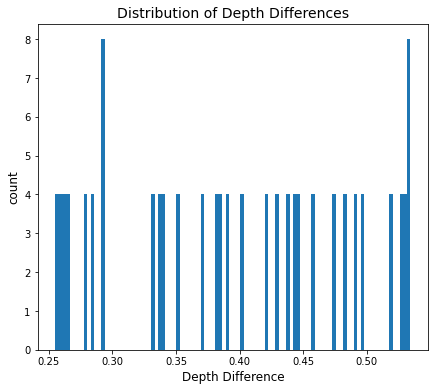

0.5345

In [139]:
print("Mean & Std: ", all_depth_diffs[1:])
plt.figure(figsize = [7,6])
plt.hist(all_depth_diffs[0], bins=100)
plt.title("Distribution of Depth Differences", fontsize = 14)
plt.xlabel("Depth Difference", fontsize = 12)
plt.ylabel("count", fontsize = 12)
plt.show()
np.amax(all_depth_diffs[0])

In [140]:
depth_diffs = np.arange(0.24,0.54, 0.04)

depth_diff_accuracy_250 = {}
depth_diff_accuracy_1000 = {}

for diff in depth_diffs:
    diff_bin_df = final_discrim[(final_discrim['depth_difference'] >= diff) & (final_discrim['depth_difference'] < diff + 0.05)]
    diff_bin_df_250ms = diff_bin_df[diff_bin_df['duration'] == 250.0]
    diff_bin_df_1000ms = diff_bin_df[diff_bin_df['duration'] == 1000.0]
    
    diff_acc_250 = get_accuracy(diff_bin_df_250ms)
    diff_acc_1000 = get_accuracy(diff_bin_df_1000ms)
    
    depth_diff_accuracy_250[round(diff, 3)] = diff_acc_250[0]
    depth_diff_accuracy_1000[round(diff, 3)] = diff_acc_1000[0]
    

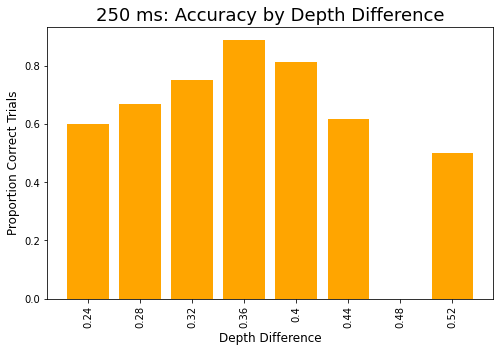

In [179]:
plt.figure(figsize = [8, 5])
plt.bar(range(len(depth_diff_accuracy_250)), list(depth_diff_accuracy_250.values()), color = 'orange')
plt.xticks(range(len(depth_diff_accuracy_250)), list(depth_diff_accuracy_250.keys()), rotation=90)
plt.xlabel("Depth Difference", fontsize = 12)
plt.ylabel("Proportion Correct Trials", fontsize = 12)
plt.title("250 ms: Accuracy by Depth Difference", fontsize = 18)
plt.show()

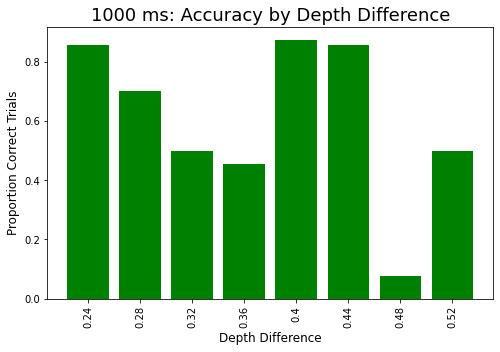

In [142]:
plt.figure(figsize = [8, 5])
plt.bar(range(len(depth_diff_accuracy_1000)), list(depth_diff_accuracy_1000.values()), color = 'green')
plt.xticks(range(len(depth_diff_accuracy_1000)), list(depth_diff_accuracy_1000.keys()), rotation=90)
plt.xlabel("Depth Difference", fontsize = 12)
plt.ylabel("Proportion Correct Trials", fontsize = 12)
plt.title("1000 ms: Accuracy by Depth Difference", fontsize = 18)
plt.show()

## Reaction Time

In [180]:
def get_RT(df):
    """
    args:
        df  
    returns:
        array of RTs, avg RT and std   
    """
    list_RTs = []
    for idx, row in df.iterrows():   
        stimulus_duration = row['log_sceneDuration2']
        RT = row["trial_RT"] - stimulus_duration
        list_RTs.append(RT)
    
    list_RTs = np.array(list_RTs)
    
    return list_RTs, np.mean(list_RTs) ,np.std(list_RTs)

Mean & Std:  (1148.9765625, 282.6546994800964)


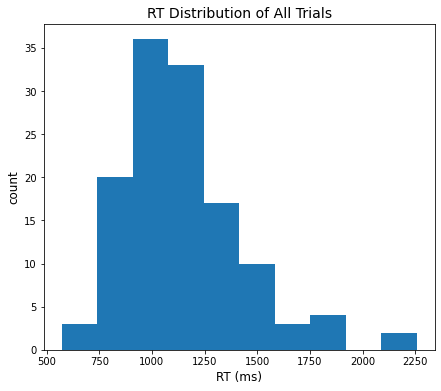

In [181]:
overall_RT = get_RT(final_discrim)
print("Mean & Std: ", overall_RT[1:])
plt.figure(figsize = [7,6])
plt.hist(overall_RT[0])
plt.title("RT Distribution of All Trials", fontsize = 14)
plt.xlabel("RT (ms)", fontsize = 12)
plt.ylabel("count", fontsize = 12)
plt.show()

In [145]:
RT_250 = get_RT(discrim_250ms)
RT_1000 = get_RT(discrim_1000ms)


Mean & Std:  (1200.258064516129, 279.5956144081196)


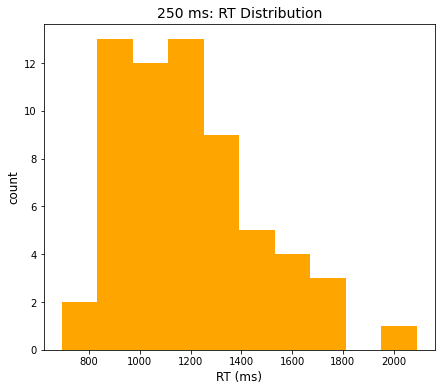

In [146]:
print("Mean & Std: ", RT_250[1:])
plt.figure(figsize = [7,6])
plt.hist(RT_250[0], color="orange")
plt.title("250 ms: RT Distribution", fontsize = 14)
plt.xlabel("RT (ms)", fontsize = 12)
plt.ylabel("count", fontsize = 12)
plt.show()

Mean & Std:  (1100.8030303030303, 276.98070273538366)


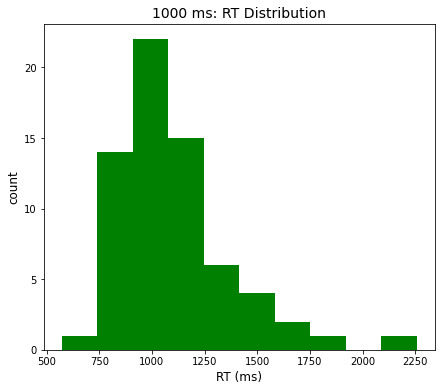

In [182]:
print("Mean & Std: ", RT_1000[1:])
plt.figure(figsize = [7,6])
plt.hist(RT_1000[0], color="green")
plt.title("1000 ms: RT Distribution", fontsize = 14)
plt.xlabel("RT (ms)", fontsize = 12)
plt.ylabel("count", fontsize = 12)
plt.show()

In [183]:
depth_bins = np.arange(1,5,0.4)
depth_bins_avgRT_250 = {}
depth_bins_stdRT_250 = {}
depth_bins_avgRT_1000 = {}
depth_bins_stdRT_1000 = {}


for _bin in depth_bins:
    bin_df = final_discrim[(final_discrim['actual_depth_0'] >= _bin) & (final_discrim['actual_depth_0'] < _bin + 0.4)]
    bin_df_250ms = bin_df[bin_df['duration'] == 250.0]
    bin_df_1000ms = bin_df[bin_df['duration'] == 1000.0]
    
    _RT_250 = get_RT(bin_df_250ms)
    _RT_1000 = get_RT(bin_df_1000ms)
    
    depth_bins_avgRT_250[round(_bin, 3)] = _RT_250[1]
    depth_bins_stdRT_250[round(_bin,3)] = _RT_250[2]
    depth_bins_avgRT_1000[round(_bin, 3)] = _RT_1000[1]
    depth_bins_stdRT_1000[round(_bin,3)] = _RT_1000[2]


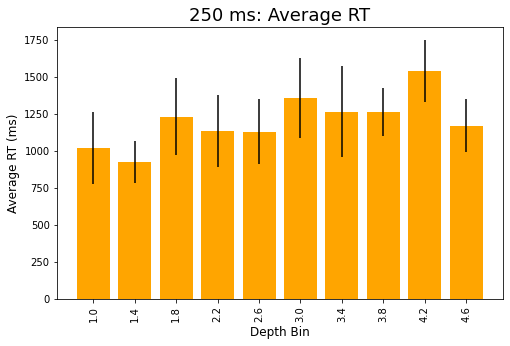

In [184]:
plt.figure(figsize = [8, 5])

plt.bar(range(len(depth_bins_avgRT_250)), list(depth_bins_avgRT_250.values()), align='center', color = 'orange',
        yerr = list(depth_bins_stdRT_250.values()))

plt.xticks(range(len(depth_bins_avgRT_250)), list(depth_bins_avgRT_250.keys()), rotation=90)
plt.xlabel("Depth Bin", fontsize = 12)
plt.ylabel("Average RT (ms)", fontsize = 12)
plt.title("250 ms: Average RT", fontsize = 18)
plt.show()

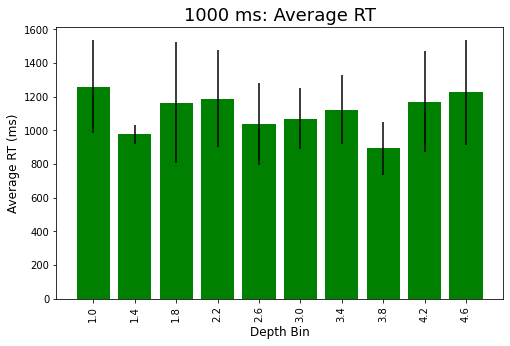

In [185]:
plt.figure(figsize = [8, 5])

plt.bar(range(len(depth_bins_avgRT_1000)), list(depth_bins_avgRT_1000.values()), align='center', color = 'green',
        yerr = list(depth_bins_stdRT_1000.values()))

plt.xticks(range(len(depth_bins_avgRT_1000)), list(depth_bins_avgRT_1000.keys()), rotation=90)
plt.xlabel("Depth Bin", fontsize = 12)
plt.ylabel("Average RT (ms)", fontsize = 12)
plt.title("1000 ms: Average RT", fontsize = 18)
plt.show()

In [186]:
depth_diffs = np.arange(0.24,0.54, 0.04)

depth_diff_RT_250 = {}
depth_diff_RT_1000 = {}

for diff in depth_diffs:
    diff_bin_df = final_discrim[(final_discrim['depth_difference'] >= diff) & (final_discrim['depth_difference'] < diff + 0.05)]
    diff_bin_df_250ms = diff_bin_df[diff_bin_df['duration'] == 250.0]
    diff_bin_df_1000ms = diff_bin_df[diff_bin_df['duration'] == 1000.0]
    
    diff_RT_250 = get_RT(diff_bin_df_250ms)
    diff_RT_1000 = get_RT(diff_bin_df_1000ms)
    
    depth_diff_RT_250[round(diff, 3)] = diff_RT_250[1]
    depth_diff_RT_1000[round(diff, 3)] = diff_RT_1000[1]
    

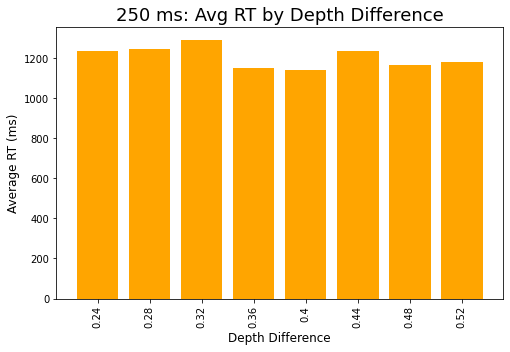

In [187]:
plt.figure(figsize = [8, 5])
plt.bar(range(len(depth_diff_RT_250)), list(depth_diff_RT_250.values()), color = 'orange')
plt.xticks(range(len(depth_diff_RT_250)), list(depth_diff_RT_250.keys()), rotation=90)
plt.xlabel("Depth Difference", fontsize = 12)
plt.ylabel("Average RT (ms)", fontsize = 12)
plt.title("250 ms: Avg RT by Depth Difference", fontsize = 18)
plt.show()

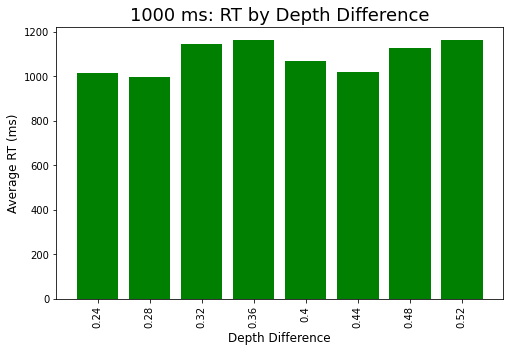

In [188]:
plt.figure(figsize = [8, 5])
plt.bar(range(len(depth_diff_RT_1000)), list(depth_diff_RT_1000.values()), color = 'green')
plt.xticks(range(len(depth_diff_RT_1000)), list(depth_diff_RT_1000.keys()), rotation=90)
plt.xlabel("Depth Difference", fontsize = 12)
plt.ylabel("Average RT (ms)", fontsize = 12)
plt.title("1000 ms: RT by Depth Difference", fontsize = 18)
plt.show()

## Individual Discriminations

In [189]:
def individual_discrimination_stats(df):
    '''
    Individual discrimination performance and RT 
    '''
    all_stim0 = df.stimulus_0.unique()
    
    stimuli_stats = {}
    for stim0 in all_stim0:
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
        
        stim_depthdiff = stim_df['depth_difference'][0]
        
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        stim_acc_250 = get_accuracy(stim_250_df)
        stim_acc_1000 = get_accuracy(stim_1000_df)
        
        stim_RT_250 = get_RT(stim_250_df)
        stim_RT_1000 = get_RT(stim_1000_df)
        
        stimuli_stats[stim0] = {'accuracy_250': stim_acc_250,
                                'accuracy_1000': stim_acc_1000,
                                'avg_depth': stim_depthbin,
                                'depthdifference': stim_depthdiff, 
                                'RT_250': stim_RT_250,
                                'RT_1000': stim_RT_1000}
    
    return stimuli_stats

In [190]:
all_discrim_performance = individual_discrimination_stats(final_discrim)


In [191]:
# all_discrim_performance['depth_discrimination_stimuli/001175_2014-06-17_15-45-55_260595134347_rgbf000129-resize_4/001175_2014-06-17_15-45-55_260595134347_rgbf000129-resize_4-target.png']


### Prep accuracy data for plotting

In [192]:
# x = average depth of the targets 
final_x_250 = [all_discrim_performance[key]['avg_depth'] for key in all_discrim_performance]
# y = depth difference of the targets
final_y_250 = [all_discrim_performance[key]['depthdifference'] for key in all_discrim_performance]
# z = proportion correct 
final_z_250 = [all_discrim_performance[key]['accuracy_250'][0] for key in all_discrim_performance]


final_x_250[0], final_y_250[0], final_z_250[0]

(1.6135000000000002, 0.518, 0.0)

In [193]:
# x = average depth of the targets 
final_x_1000 = [all_discrim_performance[key]['avg_depth'] for key in all_discrim_performance]
# y = depth difference of the targets
final_y_1000 = [all_discrim_performance[key]['depthdifference'] for key in all_discrim_performance]
# z = proportion correct 
final_z_1000 = [all_discrim_performance[key]['accuracy_1000'][0] for key in all_discrim_performance]

final_x_1000[0], final_y_1000[0], final_z_1000[0]

(1.6135000000000002, 0.518, 0.0)

https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

Text(0.5, 0.92, 'Individulal Discrimination Performance: 250 ms')

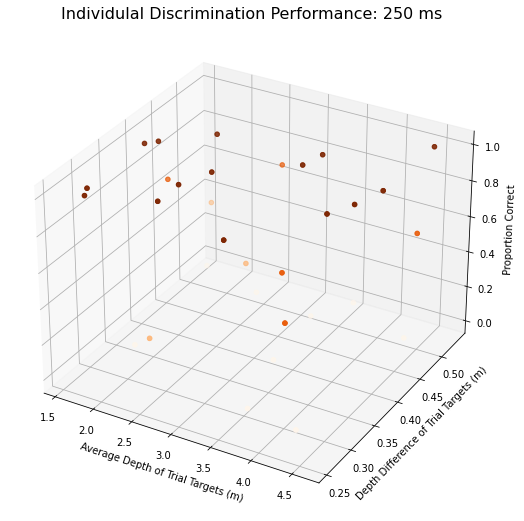

In [194]:
fig = plt.figure(figsize=[9,9])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = np.array(final_z_250)
xdata = np.array(final_x_250)
ydata = np.array(final_y_250)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Oranges');
ax.set_xlabel('Average Depth of Trial Targets (m)')
ax.set_ylabel('Depth Difference of Trial Targets (m)')
ax.set_zlabel('Proportion Correct');
ax.set_title('Individulal Discrimination Performance: 250 ms', fontsize=16)

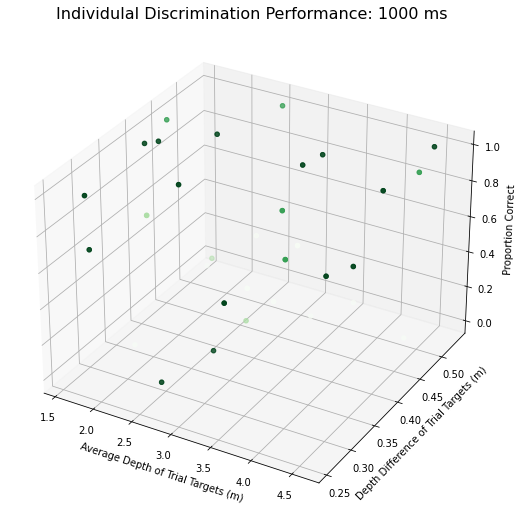

In [195]:
fig = plt.figure(figsize=[9,9])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata1000 = np.array(final_z_1000)
xdata1000 = np.array(final_x_1000)
ydata1000 = np.array(final_y_1000)
ax.scatter3D(xdata1000, ydata1000, zdata1000, c=zdata, cmap='Greens');
ax.set_xlabel('Average Depth of Trial Targets (m)')
ax.set_ylabel('Depth Difference of Trial Targets (m)')
ax.set_zlabel('Proportion Correct');
ax.set_title('Individulal Discrimination Performance: 1000 ms', fontsize=16)
plt.show();

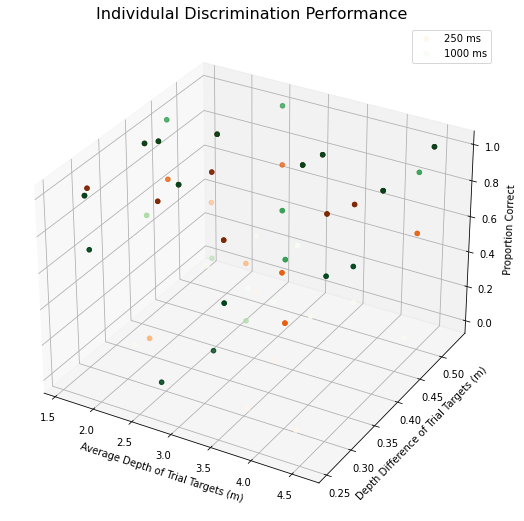

In [196]:
fig = plt.figure(figsize=[9,9])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata1000 = np.array(final_z_1000)
xdata1000 = np.array(final_x_1000)
ydata1000 = np.array(final_y_1000)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Oranges', label='250 ms');
ax.scatter3D(xdata1000, ydata1000, zdata1000, c=zdata, cmap='Greens', label='1000 ms');
ax.set_xlabel('Average Depth of Trial Targets (m)')
ax.set_ylabel('Depth Difference of Trial Targets (m)')
ax.set_zlabel('Proportion Correct');
ax.set_title('Individulal Discrimination Performance', fontsize=16)
ax.legend()
plt.show();

10

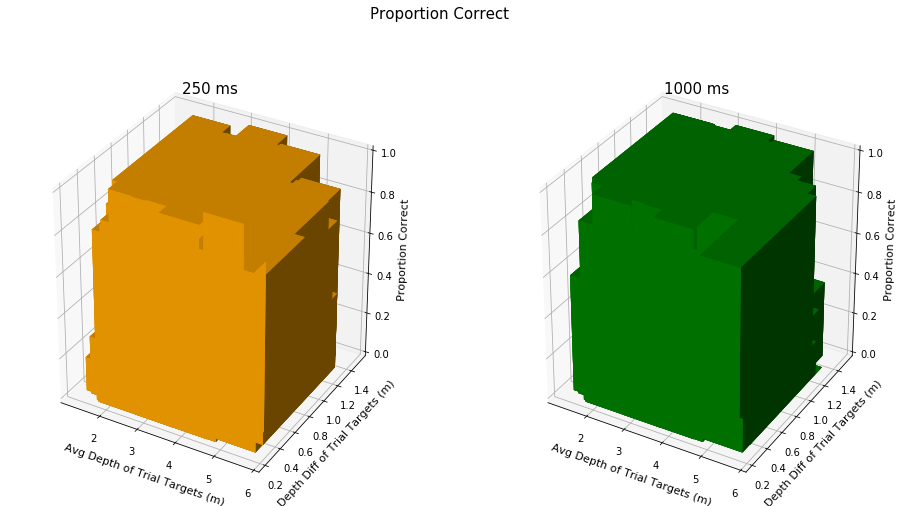

In [204]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

num_elements = len(xpos)
zpos = [0] * num_elements
dx = np.ones(num_elements)
dy = np.ones(num_elements)

ax1.bar3d(final_x_250, final_y_250, zpos, dx, dy, final_z_250, color='orange', shade=True)
ax1.set_title('250 ms', fontsize=15)
ax1.set_xlabel('Avg Depth of Trial Targets (m)', fontsize=11)
ax1.set_ylabel('Depth Diff of Trial Targets (m)', fontsize=11)
ax1.set_zlabel('Proportion Correct', fontsize=11)

ax2.bar3d(final_x_1000, final_y_1000, zpos, dx, dy, final_z_1000, color='green', shade=True)
ax2.set_title('1000 ms', fontsize=15)
ax2.set_xlabel('Avg Depth of Trial Targets (m)', fontsize=11)
ax2.set_ylabel('Depth Diff of Trial Targets (m)', fontsize=11)
ax2.set_zlabel('Proportion Correct', fontsize=11)
fig.suptitle('Proportion Correct', fontsize=15)

plt.show();

m: [0.00973537]
b: 0.3350879999590952
R-squared:  0.011689103952097104


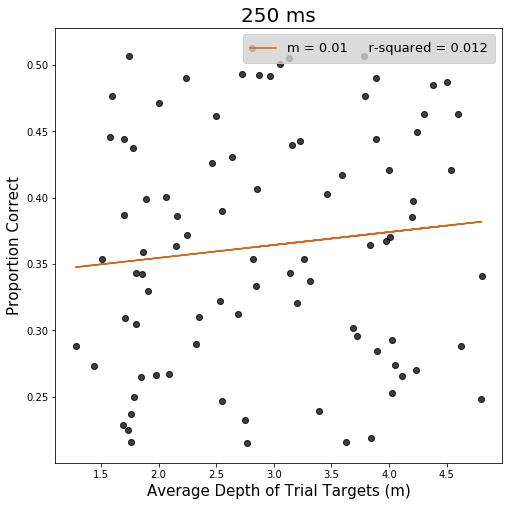

In [56]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize = [8,8])
#run regression
X_250 = np.array(final_x_250).reshape(-1,1)
y_250 = final_y_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.plot(X_250, y_250, 'o', color='black', alpha = 0.5);
plt.plot(X_250,y_predicted_250,color='chocolate', label = 'm = ' + str(round(reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(reg_250.score(X_250, y_250)), 3)))

plt.title("250 ms",  fontsize = 20)
plt.xlabel("Average Depth of Trial Targets (m)", fontsize = 15)
plt.ylabel("Proportion Correct", fontsize = 15)

# plt.errorbar(X_250, y_250, yerr=ste_250, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "chocolate", mec = "chocolate", capsize = 3)

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')




#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

### Prep RT data for plotting

In [197]:
# x = average depth of the targets 
final_x_250_RT = [all_discrim_performance[key]['avg_depth'] for key in all_discrim_performance]
# y = depth difference of the targets
final_y_250_RT = [all_discrim_performance[key]['depthdifference'] for key in all_discrim_performance]
# z = average RT 
final_z_250_RT = [all_discrim_performance[key]['RT_250'][1] for key in all_discrim_performance]


final_x_250_RT[0], final_y_250_RT[0], final_z_250_RT[0]

(1.6135000000000002, 0.518, 731.0)

In [198]:
# x = average depth of the targets 
final_x_1000_RT = [all_discrim_performance[key]['avg_depth'] for key in all_discrim_performance]
# y = depth difference of the targets
final_y_1000_RT = [all_discrim_performance[key]['depthdifference'] for key in all_discrim_performance]
# z = average RT 
final_z_1000_RT = [all_discrim_performance[key]['RT_1000'][1] for key in all_discrim_performance]


final_x_1000_RT[0], final_y_1000_RT[0], final_z_1000_RT[0]

(1.6135000000000002, 0.518, 1233.0)

Text(0.5, 0.92, 'Individulal Discrimination Avg RT: 250 ms')

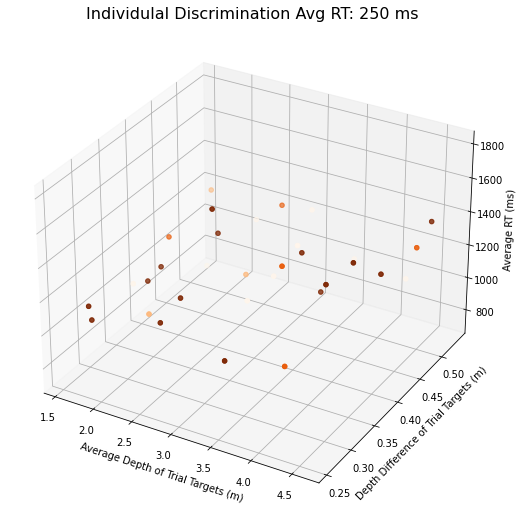

In [199]:
fig = plt.figure(figsize=[9,9])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata_RT = np.array(final_z_250_RT)
xdata_RT = np.array(final_x_250_RT)
ydata_RT = np.array(final_y_250_RT)
ax.scatter3D(xdata_RT, ydata_RT, zdata_RT, c=zdata, cmap='Oranges');
ax.set_xlabel('Average Depth of Trial Targets (m)')
ax.set_ylabel('Depth Difference of Trial Targets (m)')
ax.set_zlabel('Average RT (ms)');
ax.set_title('Individulal Discrimination Avg RT: 250 ms', fontsize=16)

Text(0.5, 0.92, 'Individulal Discrimination Avg RT: 1000 ms')

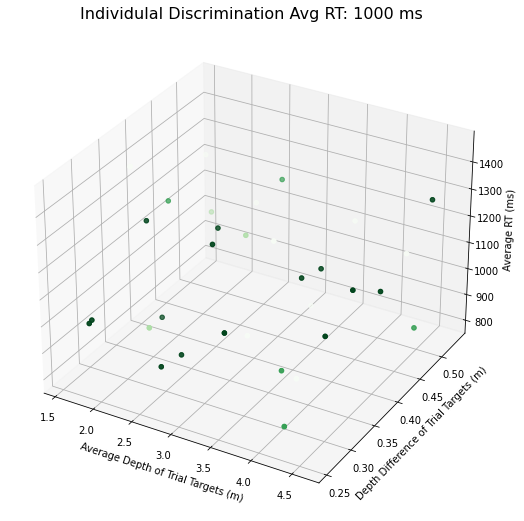

In [200]:
fig = plt.figure(figsize=[9,9])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata_RT_1000 = np.array(final_z_1000_RT)
xdata_RT_1000 = np.array(final_x_1000_RT)
ydata_RT_1000 = np.array(final_y_1000_RT)
ax.scatter3D(xdata_RT_1000, ydata_RT_1000, zdata_RT_1000, c=zdata, cmap='Greens');
ax.set_xlabel('Average Depth of Trial Targets (m)')
ax.set_ylabel('Depth Difference of Trial Targets (m)')
ax.set_zlabel('Average RT (ms)');
ax.set_title('Individulal Discrimination Avg RT: 1000 ms', fontsize=16)

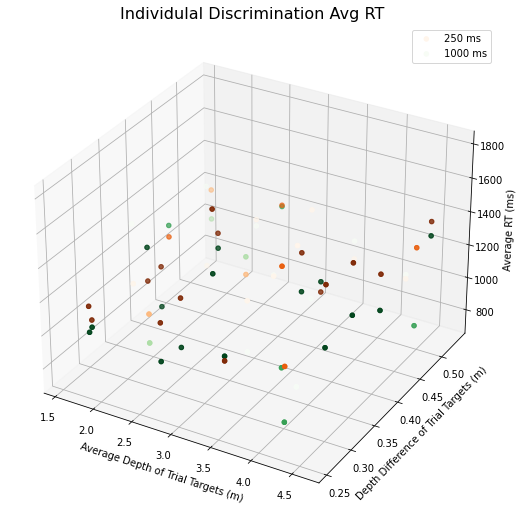

In [201]:
fig = plt.figure(figsize=[9,9])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata_RT_1000 = np.array(final_z_1000_RT)
xdata_RT_1000 = np.array(final_x_1000_RT)
ydata_RT_1000 = np.array(final_y_1000_RT)
ax.scatter3D(xdata_RT, ydata_RT, zdata_RT, c=zdata, cmap='Oranges', label='250 ms');
ax.scatter3D(xdata_RT_1000, ydata_RT_1000, zdata_RT_1000, c=zdata, cmap='Greens', label='1000 ms');
ax.set_xlabel('Average Depth of Trial Targets (m)')
ax.set_ylabel('Depth Difference of Trial Targets (m)')
ax.set_zlabel('Average RT (ms)');
ax.set_title('Individulal Discrimination Avg RT', fontsize=16)
ax.legend()
plt.show();

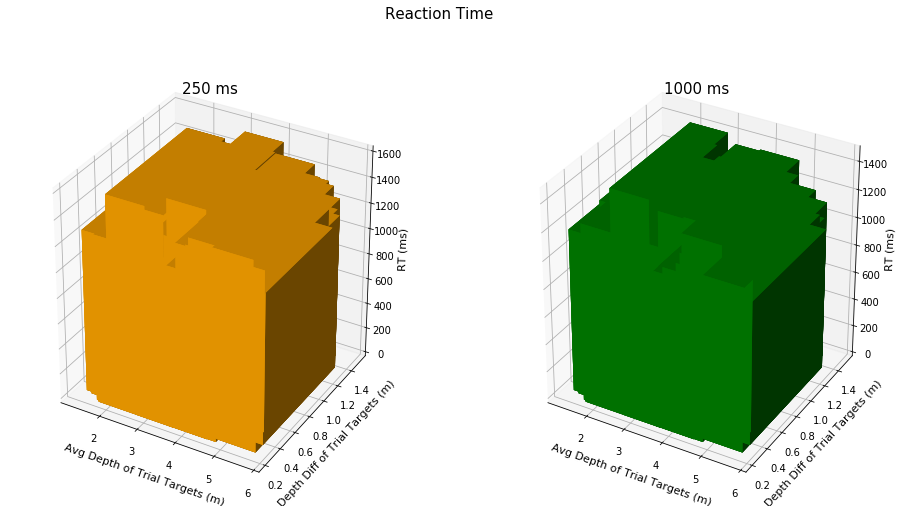

In [208]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

num_elements = len(xpos)
zpos = [0] * num_elements
dx = np.ones(num_elements)
dy = np.ones(num_elements)

ax1.bar3d(final_x_250, final_y_250, zpos, dx, dy, final_z_250_RT, color='orange', shade=True)
ax1.set_title('250 ms', fontsize=15)
ax1.set_xlabel('Avg Depth of Trial Targets (m)', fontsize=11)
ax1.set_ylabel('Depth Diff of Trial Targets (m)', fontsize=11)
ax1.set_zlabel('RT (ms)', fontsize=11)

ax2.bar3d(final_x_1000, final_y_1000, zpos, dx, dy, final_z_1000_RT, color='green', shade=True)
ax2.set_title('1000 ms', fontsize=15)
ax2.set_xlabel('Avg Depth of Trial Targets (m)', fontsize=11)
ax2.set_ylabel('Depth Diff of Trial Targets (m)', fontsize=11)
ax2.set_zlabel('RT (ms)', fontsize=11)
fig.suptitle('Reaction Time', fontsize=15)

plt.show();

## Inverse Efficiency Score

It is calculated by dividing RT by 1 – the proportion of Errors (PE), or the proportion of correct responses (PC).

https://www.readcube.com/articles/10.5334/pb-51-1-5

In [202]:
def inverse_efficiency_score(PC, RT):
    """
    Input:
        PC - proportion correct
        RT - reaction time 
    Output:
        ies - inverse efficiency score
    """
    
    ies = RT / PC
    
    return ies

In [203]:
ies_250 = [inverse_efficiency_score(all_discrim_performance[key]['accuracy_250'][0], all_discrim_performance[key]['RT_250'][1]) for key in all_discrim_performance]

ies_1000 = [inverse_efficiency_score(all_discrim_performance[key]['accuracy_1000'][0], all_discrim_performance[key]['RT_1000'][1]) for key in all_discrim_performance]


/Users/prachi/Documents/depth_duration/experiment/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [204]:
ies_250[0]

inf

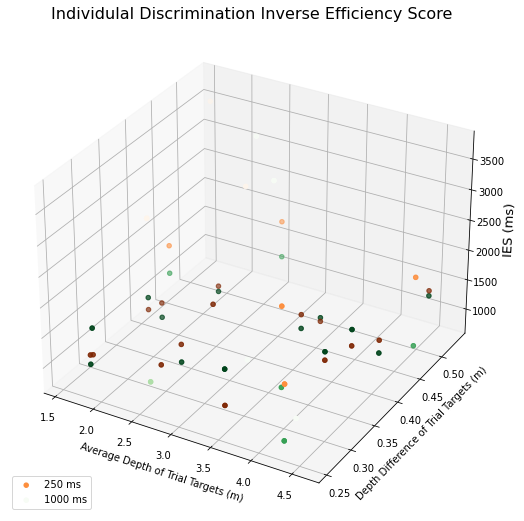

In [205]:
fig = plt.figure(figsize=[9,9])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
xdata_RT_1000 = np.array(final_x_1000_RT)
ydata_RT_1000 = np.array(final_y_1000_RT)
ax.scatter3D(xdata_RT, ydata_RT, np.array(ies_250), c=zdata, cmap='Oranges', label='250 ms');
ax.scatter3D(xdata_RT_1000, ydata_RT_1000, np.array(ies_1000), c=zdata, cmap='Greens', label='1000 ms');
ax.set_xlabel('Average Depth of Trial Targets (m)')
ax.set_ylabel('Depth Difference of Trial Targets (m)')
ax.set_zlabel('IES (ms)', fontsize = 13);
ax.set_title('Individulal Discrimination Inverse Efficiency Score', fontsize=16)
ax.legend(loc='lower left')
plt.show();

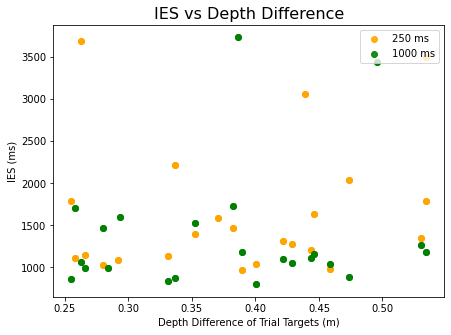

In [207]:
plt.figure(figsize=[7,5])
plt.plot(ydata_RT, np.array(ies_250), 'o', color='orange', alpha = 0.9, label='250 ms')
plt.plot(ydata_RT_1000, np.array(ies_1000), 'o', color='green', alpha = 0.9, label='1000 ms')
plt.xlabel('Depth Difference of Trial Targets (m)')
plt.ylabel('IES (ms)')
plt.legend(loc='upper right')
plt.title('IES vs Depth Difference', fontsize=16)
plt.show();



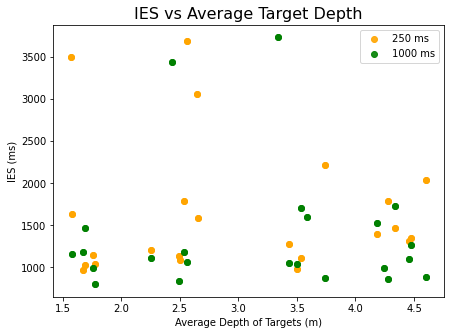

In [208]:
plt.figure(figsize=[7,5])
plt.plot(xdata_RT, np.array(ies_250), 'o', color='orange', alpha = 0.9, label='250 ms')
plt.plot(xdata_RT_1000, np.array(ies_1000), 'o', color='green', alpha = 0.9, label='1000 ms')
plt.xlabel('Average Depth of Targets (m)')
plt.ylabel('IES (ms)')
plt.legend(loc='upper right')
plt.title('IES vs Average Target Depth', fontsize=16)
plt.show();



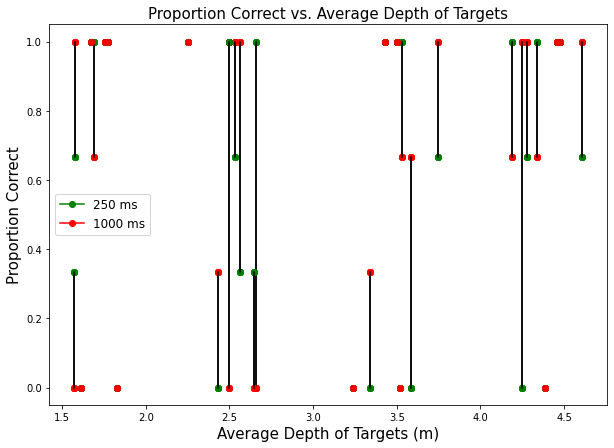

20


In [209]:
plt.figure(figsize = [10,7])
count_1000_higher = 0
for i in range(len(final_x_250)):
    avgdepth = final_x_250[i]
    pc250 = final_z_250[i]
    pc1000 = final_z_1000[i]
    if pc1000 > pc250:
        count_1000_higher += 1
    
    point1 = [avgdepth, pc250]
    point2 = [avgdepth, pc1000]
    
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    
    plt.plot(point1[0],point1[1],'-go') 
    plt.plot(point2[0],point2[1],'-ro') 
    if i == 0:
        plt.plot(point1[0],point1[1],'-go', label='250 ms') 
        plt.plot(point2[0],point2[1],'-ro', label='1000 ms') 
    else:
        plt.plot(point1[0],point1[1],'-go') 
        plt.plot(point2[0],point2[1],'-ro') 

    plt.plot(x_values, y_values, color='black')

plt.xlabel('Average Depth of Targets (m)', fontsize=15)
plt.ylabel('Proportion Correct', fontsize=15)
plt.legend(fontsize = 12)
plt.title('Proportion Correct vs. Average Depth of Targets', fontsize=15)
plt.show();
print(count_1000_higher)

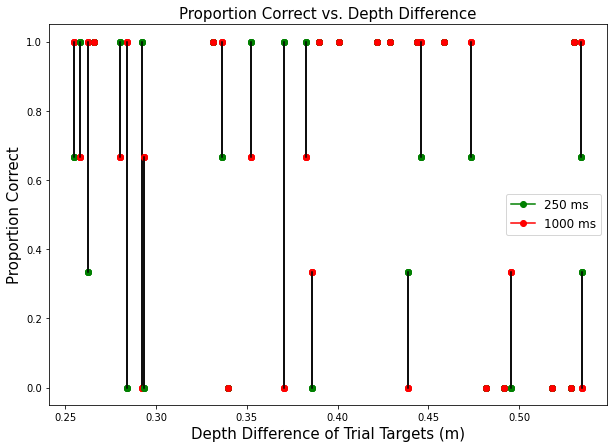

In [210]:
plt.figure(figsize = [10,7])
for i in range(len(final_x_250)):
    depthdiff = final_y_250[i]
    pc250 = final_z_250[i]
    pc1000 = final_z_1000[i]
    
    point1 = [depthdiff, pc250]
    point2 = [depthdiff, pc1000]
    
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    
    plt.plot(point1[0],point1[1],'-go') 
    plt.plot(point2[0],point2[1],'-ro') 
    if i == 0:
        plt.plot(point1[0],point1[1],'-go', label='250 ms') 
        plt.plot(point2[0],point2[1],'-ro', label='1000 ms') 
    else:
        plt.plot(point1[0],point1[1],'-go') 
        plt.plot(point2[0],point2[1],'-ro') 

    plt.plot(x_values, y_values, color='black')

plt.xlabel('Depth Difference of Trial Targets (m)', fontsize=15)
plt.ylabel('Proportion Correct', fontsize=15)
plt.legend(fontsize = 12)
plt.title('Proportion Correct vs. Depth Difference', fontsize=15)
plt.show();

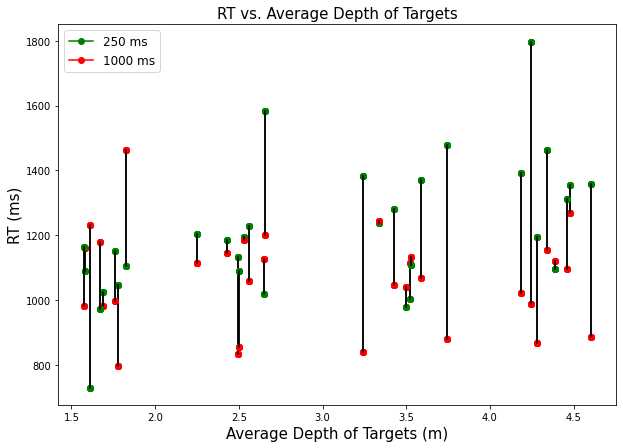

In [211]:
plt.figure(figsize = [10,7])
for i in range(len(final_x_250)):
    avgdepth = final_x_250[i]
    pc250 = final_z_250_RT[i]
    pc1000 = final_z_1000_RT[i]
    
    point1 = [avgdepth, pc250]
    point2 = [avgdepth, pc1000]
    
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    
    plt.plot(point1[0],point1[1],'-go') 
    plt.plot(point2[0],point2[1],'-ro') 
    if i == 0:
        plt.plot(point1[0],point1[1],'-go', label='250 ms') 
        plt.plot(point2[0],point2[1],'-ro', label='1000 ms') 
    else:
        plt.plot(point1[0],point1[1],'-go') 
        plt.plot(point2[0],point2[1],'-ro') 

    plt.plot(x_values, y_values, color='black')

plt.xlabel('Average Depth of Targets (m)', fontsize=15)
plt.ylabel('RT (ms)', fontsize=15)
plt.legend(fontsize = 12)
plt.title('RT vs. Average Depth of Targets', fontsize=15)
plt.show();

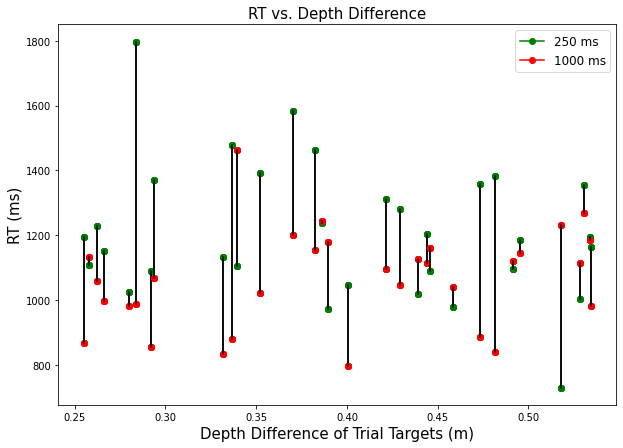

In [212]:
plt.figure(figsize = [10,7])
for i in range(len(final_x_250)):
    depthdiff = final_y_250[i]
    pc250 = final_z_250_RT[i]
    pc1000 = final_z_1000_RT[i]
    
    point1 = [depthdiff, pc250]
    point2 = [depthdiff, pc1000]
    
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    
    plt.plot(point1[0],point1[1],'-go') 
    plt.plot(point2[0],point2[1],'-ro') 
    if i == 0:
        plt.plot(point1[0],point1[1],'-go', label='250 ms') 
        plt.plot(point2[0],point2[1],'-ro', label='1000 ms') 
    else:
        plt.plot(point1[0],point1[1],'-go') 
        plt.plot(point2[0],point2[1],'-ro') 

    plt.plot(x_values, y_values, color='black')

plt.xlabel('Depth Difference of Trial Targets (m)', fontsize=15)
plt.ylabel('RT (ms)', fontsize=15)
plt.legend(fontsize = 12)
plt.title('RT vs. Depth Difference', fontsize=15)
plt.show();

In [68]:
# all_discrim_performance['depth_discrimination_stimuli/001175_2014-06-17_15-45-55_260595134347_rgbf000129-resize_4/001175_2014-06-17_15-45-55_260595134347_rgbf000129-resize_4-target.png']


In [468]:
# stim_df[['subjID', 'stimulus_0', 'actual_depth_0', 'stimulus_1', 'actual_depth_1', 'depth_difference', 'discrim_choice']]